In [2]:
from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.BB84TrainableProtocol import BB84TrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer, EntangledLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


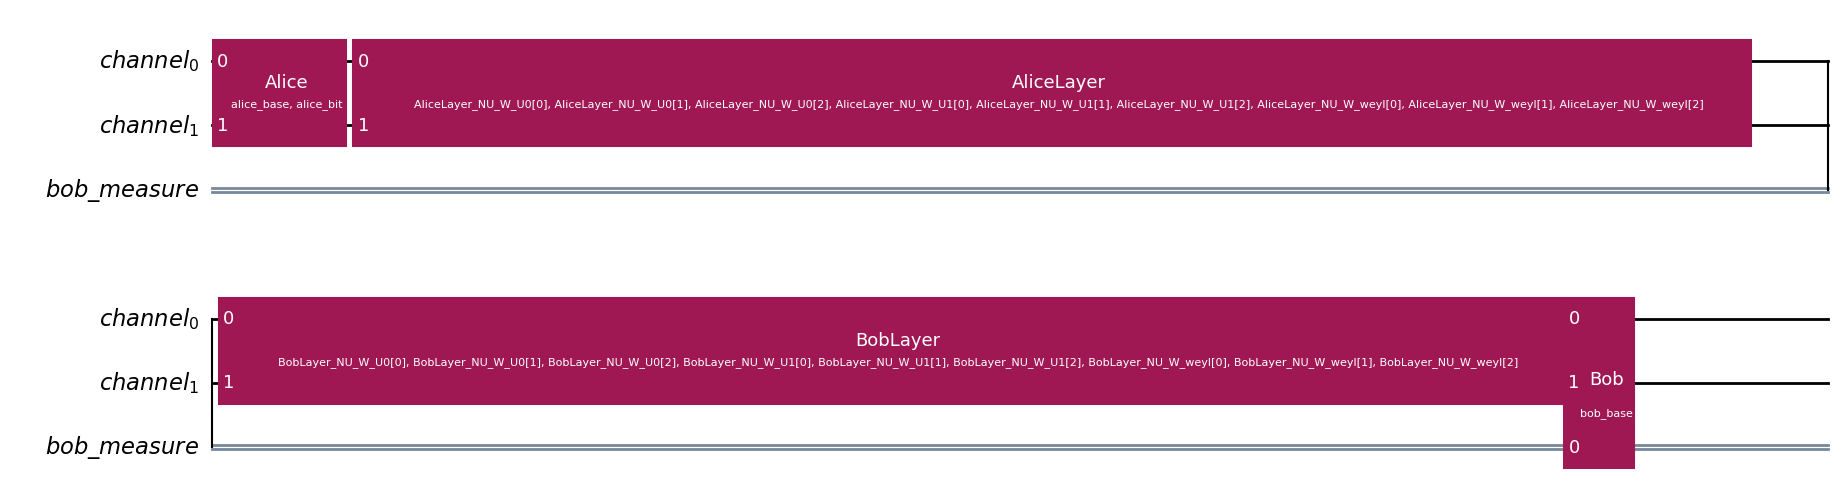

In [3]:
layers = [EntangledLayer("AliceLayer"), EntangledLayer("BobLayer")]
eve = MultiQubitQCLEve()

ab_protocol = BB84TrainableProtocol(n_bits=512, elements=layers, channel_size=2, seed=0, learning_rate=0.1)
eve_protocol = BB84EveTrainableProtocol(n_bits=512, elements=[layers[0], eve, layers[1]], channel_size=2,
                                        seed=0, )

qc, _ = ab_protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [4]:
def train_eve():
    bob_qber, eve_qber = [], []
    qber = eve_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    print(f'start QBER: {qber}')
    for epoch in range(50):
        loss = eve_protocol.train()
        qber = eve_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

def train_ab():
    qber = ab_protocol.run()
    print(f'start QBER: {qber}')
    for epoch in range(20):
        loss = ab_protocol.train()
        qber = ab_protocol.run()
        if epoch % 5 == 0:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')

# Krok 1 - trenowanie Alice i Boba do początkowego stanu
Uczymy Alice i Boba bez Eve, aby miały sensowne parametry początkowe i potrafiły przekazywać sobie dane.

In [5]:
train_ab()

start QBER: {'bob_qber': np.float64(0.503968253968254)}
epoch: 0, loss: -0.5055526494979858, QBER: {'bob_qber': np.float64(0.3492063492063492)}
epoch: 5, loss: -0.9236477613449097, QBER: {'bob_qber': np.float64(0.10317460317460314)}
epoch: 10, loss: -0.9550735950469971, QBER: {'bob_qber': np.float64(0.03968253968253965)}
epoch: 15, loss: -0.9788482189178467, QBER: {'bob_qber': np.float64(0.007936507936507908)}


# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8

In [6]:
eve_protocol.set_parameters(ab_protocol.get_all_parameters())

params = eve_protocol.get_all_parameters()
for p in eve.nu.params():
    k = p.name
    params[k] = 0

eve_protocol.set_parameters(params)
eve_protocol.freeze_elements(layers)
print(eve_protocol.get_all_parameters())



No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


{'AliceLayer_NU_W_U0[0]': np.float32(0.21580629), 'AliceLayer_NU_W_U0[1]': np.float32(0.6565387), 'AliceLayer_NU_W_U0[2]': np.float32(0.110452), 'AliceLayer_NU_W_U1[0]': np.float32(-0.11278239), 'AliceLayer_NU_W_U1[1]': np.float32(-1.227016), 'AliceLayer_NU_W_U1[2]': np.float32(0.5113771), 'AliceLayer_NU_W_weyl[0]': np.float32(-0.12717718), 'AliceLayer_NU_W_weyl[1]': np.float32(0.023183642), 'AliceLayer_NU_W_weyl[2]': np.float32(-0.5765206), 'NU_W_0_0_U0[0]': np.float32(0.0), 'NU_W_0_0_U0[1]': np.float32(0.0), 'NU_W_0_0_U0[2]': np.float32(0.0), 'NU_W_0_0_U1[0]': np.float32(0.0), 'NU_W_0_0_U1[1]': np.float32(0.0), 'NU_W_0_0_U1[2]': np.float32(0.0), 'NU_W_0_0_weyl[0]': np.float32(0.0), 'NU_W_0_0_weyl[1]': np.float32(0.0), 'NU_W_0_0_weyl[2]': np.float32(0.0), 'NU_W_0_1_U0[0]': np.float32(0.0), 'NU_W_0_1_U0[1]': np.float32(0.0), 'NU_W_0_1_U0[2]': np.float32(0.0), 'NU_W_0_1_U1[0]': np.float32(0.0), 'NU_W_0_1_U1[1]': np.float32(0.0), 'NU_W_0_1_U1[2]': np.float32(0.0), 'NU_W_0_1_weyl[0]': np.

In [7]:
eve_protocol.f_value = 0.8
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.022058823529411797), 'eve_qber': np.float64(0.5)}
epoch: 0, loss: -0.33547356724739075, QBER: {'bob_qber': np.float64(0.2904411764705882), 'eve_qber': np.float64(0.48897058823529416)}
epoch: 5, loss: -0.5698606371879578, QBER: {'bob_qber': np.float64(0.22426470588235292), 'eve_qber': np.float64(0.36764705882352944)}
epoch: 10, loss: -0.7755215167999268, QBER: {'bob_qber': np.float64(0.25735294117647056), 'eve_qber': np.float64(0.1875)}
epoch: 15, loss: -0.8096344470977783, QBER: {'bob_qber': np.float64(0.15441176470588236), 'eve_qber': np.float64(0.19117647058823528)}
epoch: 20, loss: -0.832538366317749, QBER: {'bob_qber': np.float64(0.2279411764705882), 'eve_qber': np.float64(0.16176470588235292)}
epoch: 25, loss: -0.855463981628418, QBER: {'bob_qber': np.float64(0.18014705882352944), 'eve_qber': np.float64(0.12867647058823528)}
epoch: 30, loss: -0.8568817973136902, QBER: {'bob_qber': np.float64(0.23161764705882348), 'eve_qber': np.float64(0.15441

<module 'matplotlib.pyplot' from '/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/matplotlib/pyplot.py'>

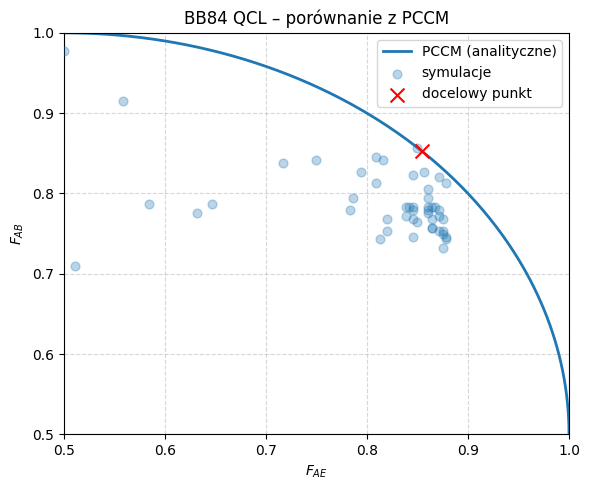

In [8]:
plt_fab_fae(b_q, e_q, 0.8)

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [ ]:
eve_protocol.freeze_elements([eve])

In [ ]:
def bob_loss(target, mask, outputs):
    bob_Z = outputs["channel"][:, 0]

    sign = 1 - 2 * target.long()
    bob_f = 0.5 * (1 + sign * bob_Z)

    bob_f = bob_f[mask].mean()

    loss = -bob_f
    return loss


In [ ]:
eve_protocol.loss = bob_loss
eve_protocol.f_value = 0.9
b_q, e_q = train_eve()

In [ ]:
plt_fab_fae(b_q, e_q, 0.9)

# Końcowy obwód

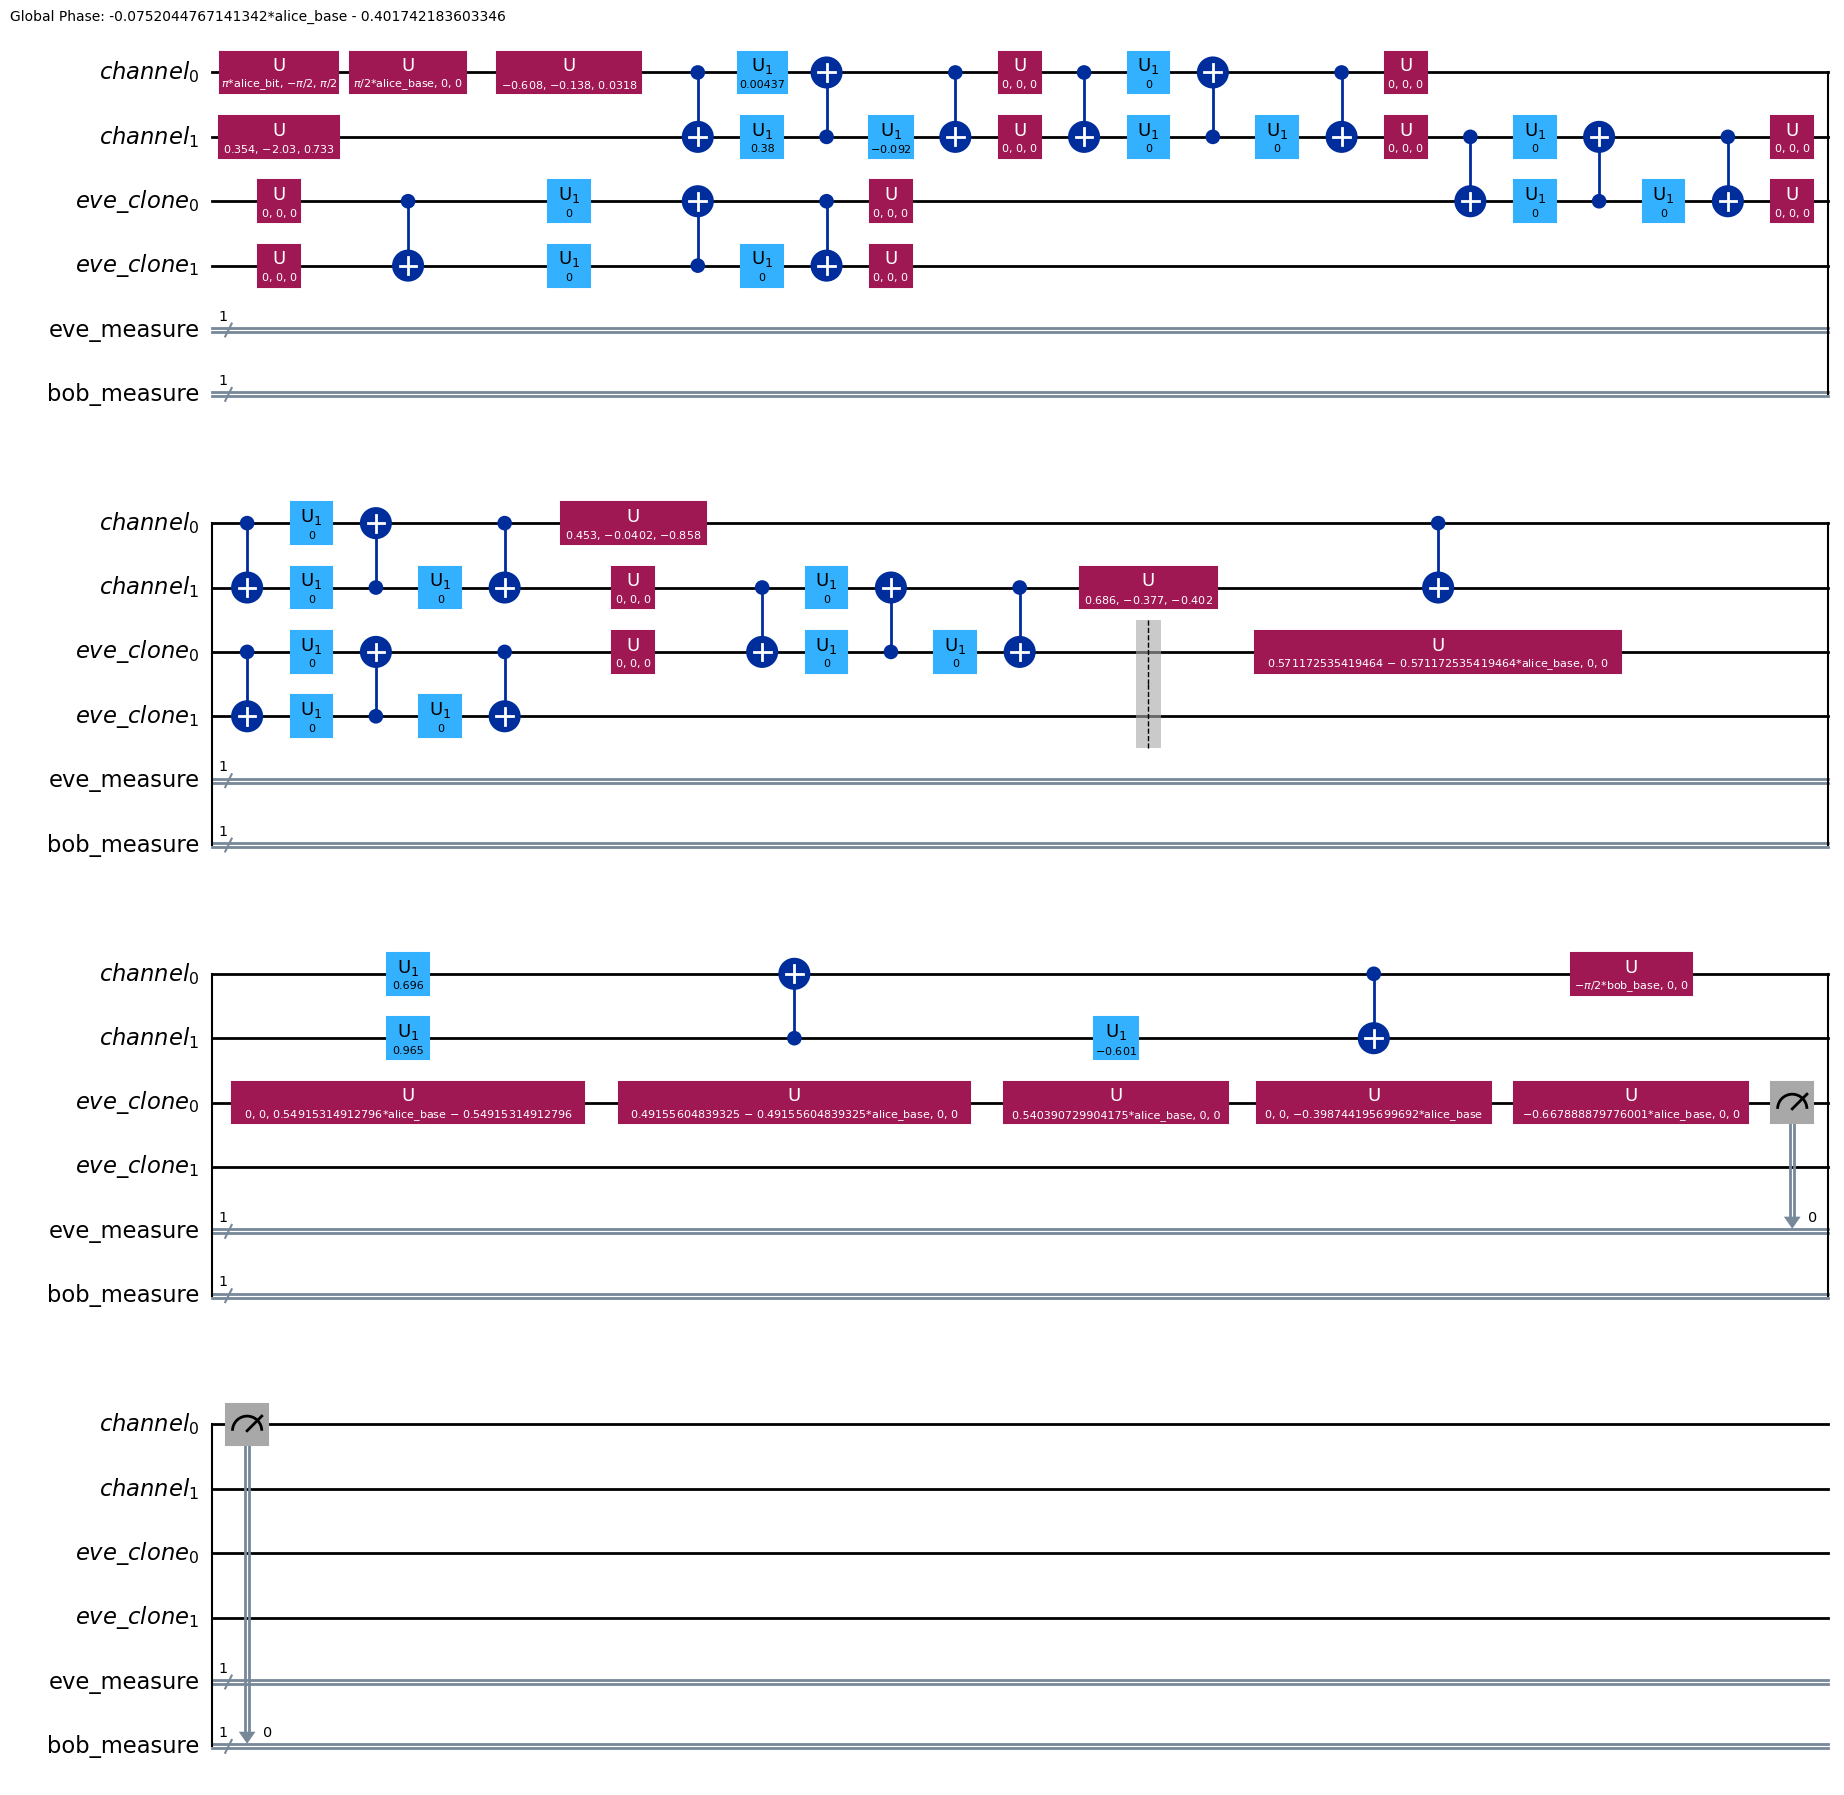

In [10]:
eve_protocol._qc.assign_parameters(eve_protocol.get_all_parameters()).draw("mpl")